# Setup
-  Follow the setup instructions based on your preferred environment!

## Local

One of our key goals in designing this assignment is to allow you to complete most of the preliminary implementation work locally.  
We highly recommend that you **pass all tests locally** using the provided `hw4_data_subset` before moving to a GPU runtime.  
To do this, simply:

### Create a new conda environment
```bash
# Be sure to deactivate any active environments first
conda create -n hw4 python=3.12.4
```

### Activate the conda environment
```bash
conda activate hw4
```

### Install the dependencies using the provided `requirements.txt`
```bash
pip install --no-cache-dir --ignore-installed -r requirements.txt
```

### Ensure that your notebook is in the same working directory as the `Handout`
This can be achieved by:
1. Physically moving the notebook into the handout directory.
2. Changing the notebook’s current working directory to the handout directory using the os.chdir() function.

### Open the notebook and select the newly created environment from the kernel selector.

If everything was done correctly, You should see atleast the following files in your current working directory after running `!ls`:
```
.
├── README.md
├── requirements.txt
├── hw4lib/
├── mytorch/
├── tests/
└── hw4_data_subset/
```

## Colab

### Step 1: Get your handout
- See writeup for recommended approaches.

### Step 2: Install Dependencies
- `NOTE`: Your runtime will be restarted to ensure all dependencies are updated.
- `NOTE`: You will see a runtime crashed message, this was intentionally done. Simply move on to the next cell.

# Imports

- If your setup was done correctly, you should be able to run the following cell without any issues.

In [1]:
from hw4lib.data import (
    H4Tokenizer,
    LMDataset,
    verify_dataloader
)
from hw4lib.model import (
    CausalMask,
    PadMask,
    PositionalEncoding,
    DecoderOnlyTransformer
)
from hw4lib.utils import (
    create_optimizer,
    create_scheduler,
    plot_lr_schedule
)
from hw4lib.trainers import (
    LMTrainer,
)
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import yaml
import gc
import torch
from torchinfo import summary
import os
import json
import tarfile
import shutil
import wandb
import yaml
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


# Implementations

- `NOTE`: All of these implementations have detailed specification, implementation details, and hints in their respective source files. Make sure to read all of them in their entirety to understand the implementation details!

## MyTorch Implementations
- Modify your `Linear` implementation from HW1P1 to support arbitrary number of dimensions in `mytorch/nn/linear.py`.
- Modify your `Softmax` implementation from HW1P1 to support arbitrary number of dimensions in `mytorch/nn/activation.py`.
- Implement the `ScaledDotProductAttention` class in `mytorch/nn/scaled_dot_product_attention.py`.
- Implement the `MultiHeadAttention` class in `mytorch/nn/multi_head_attention.py`.
- Run the cell below to check your implementations.


## Dataset Implementation
- Familiarize yourself with the `tokenize`, `encode`, and `decode` methods of the `H4Tokenizer` class in `hw4lib/data/tokenizer.py`. You will need to make use of these methods in both `HW4P1` and `HW4P2` both in the dataset implementations and during decoding.
- Implement the `LMDataset` class in `hw4lib/data/lm_dataset.py`.
    - You will have to implement parts of `__init__` and completely implement the `__len__`, `__getitem__` and `collate_fn` methods.
- Run the cell below to check your implementation.


In [2]:
!python -m tests.test_dataset_lm

Loading transcripts for train partition...
100%|███████████████████████████████████████| 267/267 [00:00<00:00, 8933.31it/s]

Running tests for category: LMDataset
--------------------------------------------------------------------------------

[01/01]    Running:  Test the LMDataset class
Testing __init__ method ...
Test Passed: Text files are sorted.
Test Passed: Shifted and golden transcripts are aligned.
Test Passed: All transcripts are decoded correctly after removing SOS and EOS tokens.
Testing __getitem__ method ...
Test Passed: SOS and EOS tokens are correctly placed for samples.
Test Passed: All transcripts are decoded correctly after removing SOS and EOS tokens.
Testing collate_fn method ...
Test Passed: Transcript batch has correct dimensions (2D tensor).
Test Passed: Transcript lengths are consistent with the batch size.
Test Passed: All sequences are padded to the same length.
Test Passed: Padding values are correct.
Test Passed: Batch transcripts are of correct data type.

In [3]:
%%writefile config.yaml

Name                      : "Abien"

###### Tokenization ------------------------------------------------------------
tokenization:
  token_type                : "char"       # [char, 1k, 5k, 10k]
  token_map :
      'char': 'hw4lib/data/tokenizer_jsons/tokenizer_char.json'
      '1k'  : 'hw4lib/data/tokenizer_jsons/tokenizer_1000.json'
      '5k'  : 'hw4lib/data/tokenizer_jsons/tokenizer_5000.json'
      '10k' : 'hw4lib/data/tokenizer_jsons/tokenizer_10000.json'

###### Dataset -----------------------------------------------------------------
data:                    # Currently setup for Colab assuming out setup
  root                 : "/home/agcheria/idl_assignment_Fall_2025/HW4/HW4P1/IDL-HW4/IDL-HW4/hw4_data_subset/hw4p1_data/"  # TODO: Set the root path of your data
  train_partition      : "train"  # train
  val_partition        : "val"    # val
  test_partition       : "test"   # test
  subset               : 1.0      # Load a subset of the data (for debugging, testing, etc
  batch_size           : 256      #
  NUM_WORKERS          : 2        # Set to 0 for CPU

###### Network Specs -------------------------------------------------------------
model: # Decoder-Only Language Model (HW4P1)
  d_model                   : 256
  d_ff                      : 1024
  num_layers                : 2
  num_heads                 : 2
  dropout                   : 0.0
  layer_drop_rate           : 0.0
  weight_tying              : False

###### Common Training Parameters ------------------------------------------------
training:
  use_wandb                   : True   # Toggle wandb logging
  wandb_run_id                : "none" # "none" or "run_id"
  resume                      : False  # Resume an existing run (run_id != 'none')
  epochs                      : 20
  gradient_accumulation_steps : 1
  wandb_project               : "Set-Project-Name-Here" # wandb project to log to

###### Loss ----------------------------------------------------------------------
loss: # Just good ol' CrossEntropy
  label_smoothing: 0.0

###### Optimizer -----------------------------------------------------------------
optimizer:
  name: "adam" # Options: sgd, adam, adamw
  lr: 5.0e-4   # Base learning rate

  # Common parameters
  weight_decay: 0.0001

  # Parameter groups
  param_groups:
    - name: self_attn
      patterns: []  # Will match all parameters containing keywords set their learning rate to 0.0001
      lr: 0.0001    # LR for self_attn
      layer_decay:
        enabled: False
        decay_rate: 0.8

    - name: ffn
      patterns: [] # Will match all parameters containing "ffn" and set their learning rate to 0.0001
      lr: 0.0001   # LR for ffn
      layer_decay:
        enabled: False
        decay_rate: 0.8

  # Layer-wise learning rates
  layer_decay:
    enabled: False
    decay_rate: 0.75

  # SGD specific parameters
  sgd:
    momentum: 0.9
    nesterov: True
    dampening: 0

  # Adam specific parameters
  adam:
    betas: [0.9, 0.999]
    eps: 1.0e-8
    amsgrad: False

  # AdamW specific parameters
  adamw:
    betas: [0.9, 0.999]
    eps: 1.0e-8
    amsgrad: False

###### Scheduler -----------------------------------------------------------------
scheduler:
  name: "cosine"  # Options: reduce_lr, cosine, cosine_warm

  # ReduceLROnPlateau specific parameters
  reduce_lr:
    mode: "min"  # Options: min, max
    factor: 0.1  # Factor to reduce learning rate by
    patience: 10  # Number of epochs with no improvement after which LR will be reduced
    threshold: 0.0001  # Threshold for measuring the new optimum
    threshold_mode: "rel"  # Options: rel, abs
    cooldown: 0  # Number of epochs to wait before resuming normal operation
    min_lr: 0.0000001  # Minimum learning rate
    eps: 1.0e-8  # Minimal decay applied to lr

  # CosineAnnealingLR specific parameters
  cosine:
    T_max: 15  # Maximum number of iterations
    eta_min: 1.0e-8  # Minimum learning rate
    last_epoch: -1

  # CosineAnnealingWarmRestarts specific parameters
  cosine_warm:
    T_0: 4  # Number of iterations for the first restart
    T_mult: 4  # Factor increasing T_i after each restart
    eta_min: 0.0000001  # Minimum learning rate
    last_epoch: -1

  # Warmup parameters (can be used with any scheduler)
  warmup:
    enabled: True
    type: "exponential"  # Options: linear, exponential
    epochs: 5
    start_factor: 0.1
    end_factor: 1.0

Overwriting config.yaml


In [4]:
with open('config.yaml', 'r') as file:
    config = yaml.safe_load(file)

## Tokenizer

In [5]:
Tokenizer = H4Tokenizer(
    token_map  = config['tokenization']['token_map'],
    token_type = config['tokenization']['token_type']
)

                         Tokenizer Configuration (char)                         
--------------------------------------------------------------------------------
Vocabulary size:     35

Special Tokens:
PAD:              0
UNK:              1
MASK:             2
SOS:              3
EOS:              4
BLANK:            5

Validation Example:
--------------------------------------------------------------------------------
Input text:  [SOS]HI DEEP LEARNERS[EOS]
Tokens:      ['[SOS]', 'H', 'I', ' ', 'D', 'E', 'E', 'P', ' ', 'L', 'E', 'A', 'R', 'N', 'E', 'R', 'S', '[EOS]']
Token IDs:   [3, 13, 12, 6, 16, 7, 7, 25, 6, 17, 7, 9, 15, 11, 7, 15, 14, 4]
Decoded:     [SOS]HI DEEP LEARNERS[EOS]


## Datasets

In [6]:
train_dataset  = LMDataset(
    partition  = config['data']['train_partition'],
    config     = config['data'],
    tokenizer  = Tokenizer
)

val_dataset    = LMDataset(
    partition  = config['data']['val_partition'],
    config     = config['data'],
    tokenizer  = Tokenizer
)

test_dataset   = LMDataset(
    partition  = config['data']['test_partition'],
    config     = config['data'],
    tokenizer  = Tokenizer
)

gc.collect()

Loading transcripts for train partition...


100%|██████████| 267/267 [00:00<00:00, 5764.88it/s]


Loading transcripts for val partition...


100%|██████████| 7/7 [00:00<00:00, 4022.49it/s]


Loading transcripts for test partition...


100%|██████████| 7/7 [00:00<00:00, 4336.80it/s]


225

## Dataloaders

In [7]:
train_loader    = DataLoader(
    dataset     = train_dataset,
    batch_size  = config['data']['batch_size'],
    shuffle     = True,
    num_workers = config['data']['NUM_WORKERS'] if device == 'cuda' else 0,
    pin_memory  = True,
    collate_fn  = train_dataset.collate_fn
)

val_loader      = DataLoader(
    dataset     = val_dataset,
    batch_size  = config['data']['batch_size'],
    shuffle     = False,
    num_workers = config['data']['NUM_WORKERS'] if device == 'cuda' else 0,
    pin_memory  = True,
    collate_fn  = val_dataset.collate_fn
)

test_loader     = DataLoader(
    dataset     = test_dataset,
    batch_size  = config['data']['batch_size'],
    shuffle     = False,
    num_workers = config['data']['NUM_WORKERS'] if device == 'cuda' else 0,
    pin_memory  = True,
    collate_fn  = test_dataset.collate_fn
)

### Dataloader Verification

## Calculate Max Transcript Length




Calculating the maximum transcript length across your dataset is a crucial step when working with certain transformer models.
-  We'll use sinusoidal positional encodings that must be precomputed up to a fixed maximum length.
- This maximum length is a hyperparameter that determines:
  - How long of a sequence your model can process
  - The size of your positional encoding matrix
  - Memory requirements during training and inference
- `Requirements`: For this assignment, ensure your positional encodings can accommodate at least the longest sequence in your dataset to prevent truncation. However, you can set this value higher if you anticipate using your language model to work with longer sequences in future tasks (hint: this might be useful for P2! 😉).

In [8]:
max_transcript_length = max(train_dataset.text_max_len, val_dataset.text_max_len, test_dataset.text_max_len)
print("="*50)
print(f"{'Global Max Transcript Length':<30} : {max_transcript_length}")
print("="*50)

Global Max Transcript Length   : 260


## Model

In [9]:
model_config = config['model']
model_config.update({
    'max_len': max_transcript_length,
    'num_classes': Tokenizer.vocab_size
})
model = DecoderOnlyTransformer(**model_config)

# Get some inputs from the text loader
for batch in train_loader:
    shifted_transcripts, golden_transcripts, transcript_lengths = batch
    print("Shape of shifted_transcripts : ", shifted_transcripts.shape)
    print("Shape of golden_transcripts  : ", golden_transcripts.shape)
    print("Shape of transcript_lengths  : ", transcript_lengths.shape)
    break

model_stats = summary(model, input_data=[shifted_transcripts, transcript_lengths])
print(model_stats)

Shape of shifted_transcripts :  torch.Size([256, 260])
Shape of golden_transcripts  :  torch.Size([256, 260])
Shape of transcript_lengths  :  torch.Size([256])
Layer (type:depth-idx)                        Output Shape              Param #
DecoderOnlyTransformer                        [256, 260, 35]            --
├─Embedding: 1-1                              [256, 260, 256]           8,960
├─PositionalEncoding: 1-2                     [256, 260, 256]           --
├─Dropout: 1-3                                [256, 260, 256]           --
├─ModuleList: 1-4                             --                        --
│    └─SelfAttentionDecoderLayer: 2-1         [256, 260, 256]           512
│    │    └─SelfAttentionLayer: 3-1           [256, 260, 256]           263,680
│    │    └─FeedForwardLayer: 3-2             [256, 260, 256]           526,080
│    └─SelfAttentionDecoderLayer: 2-2         [256, 260, 256]           512
│    │    └─SelfAttentionLayer: 3-3           [256, 260, 256]         

## Wandb

In [10]:
wandb.login(key="")

wandb: Currently logged in as: agcheria (agcheria-carnegie-mellon-university). Use `wandb login --relogin` to force relogin


True

## Trainer

Every time you run the trainer, it will create a new directory in the `expts` folder with the following structure:
```
expts/
    └── {run_name}/
        ├── config.yaml
        ├── model_arch.txt
        ├── checkpoints/
        │   ├── checkpoint-best-metric-model.pth
        │   └── checkpoint-last-epoch-model.pth
        ├── attn/
        │   └── {attention visualizations}
        └── text/
            └── {generated text outputs}
```

In [11]:
trainer = LMTrainer(
    model=model,
    tokenizer=Tokenizer,
    config=config,
    run_name="test-lm",
    config_file="config.yaml",
    device=device
)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Using device: cuda


### Setup Optimizer and Scheduler

You can set your own optimizer and scheduler by setting the class members in the `LMTrainer` class.
Eg:
```python
trainer.optimizer = optim.AdamW(model.parameters(), lr=config['optimizer']['lr'], weight_decay=config['optimizer']['weight_decay'])
trainer.scheduler = optim.lr_scheduler.CosineAnnealingLR(trainer.optimizer, T_max=config['training']['epochs'])
```

We also provide a utility function to create your own optimizer and scheduler with the congig and some extra bells and whistles. You are free to use it or not. Do read their code and documentation to understand how it works (`hw4lib/utils/*`).


#### Setting up the optimizer

In [12]:
trainer.optimizer = create_optimizer(
    model=model,
    opt_config=config['optimizer']
)


🔧 Configuring Optimizer:
├── Type: ADAM
├── Base LR: 0.0005
├── Weight Decay: 0.0001
├── Parameter Groups:
│   ├── Group: self_attn
│   │   ├── LR: 0.0001
│   │   └── Patterns: []
│   ├── Group: ffn
│   │   ├── LR: 0.0001
│   │   └── Patterns: []
│   └── Default Group (unmatched parameters)
└── Adam Specific:
    ├── Betas: [0.9, 0.999]
    ├── Epsilon: 1e-08
    └── AMSGrad: False


#### Creating a test scheduler and plotting the learning rate schedule


📈 Configuring Learning Rate Scheduler:
├── Type: COSINE
├── Cosine Annealing Settings:
│   ├── T_max: 15 epochs (30 steps)
│   └── Min LR: 1e-08
├── Warmup Settings:
│   ├── Duration: 5 epochs (10 steps)
│   ├── Start Factor: 0.1
│   └── End Factor: 1.0


/home/agcheria/miniconda3/envs/hw4/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


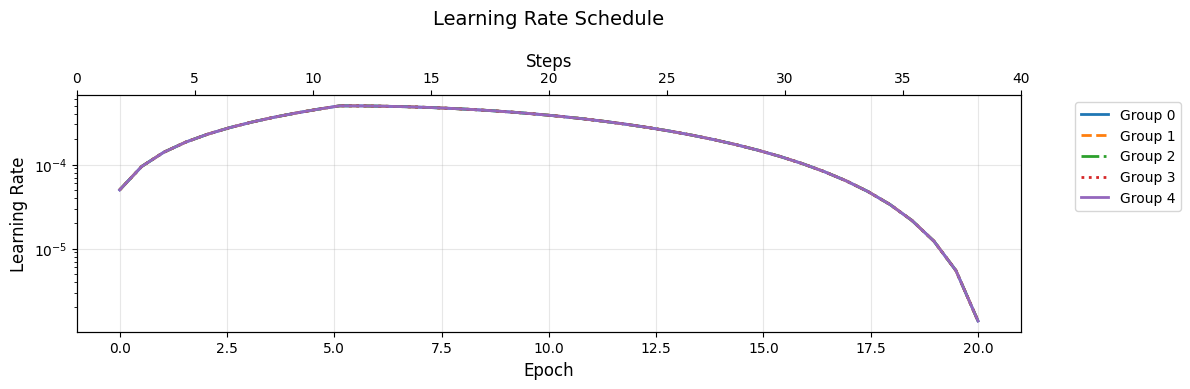

In [13]:
test_scheduler = create_scheduler(
    optimizer=trainer.optimizer,
    scheduler_config=config['scheduler'],
    train_loader=train_loader,
    gradient_accumulation_steps=config['training']['gradient_accumulation_steps']
)

plot_lr_schedule(
    scheduler=test_scheduler,
    num_epochs=config['training']['epochs'],
    train_loader=train_loader,
    gradient_accumulation_steps=config['training']['gradient_accumulation_steps']
)

#### Setting up the scheduler

In [14]:
trainer.scheduler = create_scheduler(
    optimizer=trainer.optimizer,
    scheduler_config=config['scheduler'],
    train_loader=train_loader,
    gradient_accumulation_steps=config['training']['gradient_accumulation_steps']
)


📈 Configuring Learning Rate Scheduler:
├── Type: COSINE
├── Cosine Annealing Settings:
│   ├── T_max: 15 epochs (30 steps)
│   └── Min LR: 1e-08
├── Warmup Settings:
│   ├── Duration: 5 epochs (10 steps)
│   ├── Start Factor: 0.1
│   └── End Factor: 1.0


# Train
- Set your epochs

In [15]:
trainer.train(train_loader, val_loader, epochs=config['training']['epochs'])

[Training LM]:   0%|          | 0/2 [00:00<?, ?it/s]/home/agcheria/idl_assignment_Fall_2025/HW4/HW4P1/IDL-HW4/IDL-HW4/hw4lib/trainers/lm_trainer.py:89: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


Generating with greedy search...


AttributeError: 'NoneType' object has no attribute 'ndim'

# Evaluate


In [ ]:
test_metrics, test_generation_results = trainer.evaluate(test_loader)
# Cleanup
trainer.cleanup()

# Submission
To submit your assignment, you will need to create a `handin.tar` with the following directory structure:

```
handin/
├── mytorch/                     # Your implemented modules
├── test_metrics.json            # Results from evaluation
├── test_generated_results.json  # Sample text generations
└── model_arch.txt               # Model architecture summary
```

- Simply run the cell below once you are satisfied with your current state and this will create the `handin.tar` file.
- After running the above cell, you should see the handin.tar file in the current directory
- Upload the `handin.tar` file to the `HW4P1` assignment on Autolab.

In [ ]:
# Create temporary handin directory
if os.path.exists('handin'):
    shutil.rmtree('handin')
os.makedirs('handin')

# Copy mytorch directory
shutil.copytree('mytorch', 'handin/mytorch')

# Save final results
with open('handin/test_metrics.json', 'w') as f:
    json.dump(test_metrics, f, indent=4)

with open('handin/test_generated_results.json', 'w') as f:
    json.dump(test_generation_results['greedy'], f, indent=4)

# Save model architecture
with open('handin/model_arch.txt', 'w') as f:
    f.write(str(model_stats))

# Create tar file with all exclusions handled by filter
with tarfile.open('handin.tar', 'w') as tar:
    def filter_files(tarinfo):
        # Skip unwanted files
        if any(pattern in tarinfo.name for pattern in [
            '.DS_Store',
            '__pycache__',
            '.pyc'
        ]):
            return None
        return tarinfo

    tar.add('handin', arcname='handin', filter=filter_files)

# Cleanup
shutil.rmtree('handin')

print("Created handin.tar successfully!")

## After running the above cell, you should see the handin.tar file in the current directory
!ls